# ANN vs GNN using the PNET Prostate Cancer paper dataset

In [ ]:
!python -V

Python 3.10.15


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

!printenv

cpu
SHELL=/bin/bash
SESSION_MANAGER=local/roy-NBLL-WXX9:@/tmp/.ICE-unix/2158,unix/roy-NBLL-WXX9:/tmp/.ICE-unix/2158
QT_ACCESSIBILITY=1
COLORTERM=truecolor
XDG_CONFIG_DIRS=/etc/xdg/xdg-ubuntu:/etc/xdg
NVM_INC=/home/roy/.nvm/versions/node/v20.17.0/include/node
XDG_MENU_PREFIX=gnome-
GNOME_DESKTOP_SESSION_ID=this-is-deprecated
CONDA_EXE=/home/roy/anaconda3/bin/conda
_CE_M=
JAVA_HOME=/opt/jre1.8.0_421
GNOME_SHELL_SESSION_MODE=ubuntu
SSH_AUTH_SOCK=/run/user/1000/keyring/ssh
MEMORY_PRESSURE_WRITE=c29tZSAyMDAwMDAgMjAwMDAwMAA=
XMODIFIERS=@im=ibus
DESKTOP_SESSION=ubuntu
GTK_MODULES=gail:atk-bridge
PWD=/home/roy/Documents/BRUNO/bruno_paper-main/data/pnet_cancer
XDG_SESSION_DESKTOP=ubuntu
LOGNAME=roy
XDG_SESSION_TYPE=wayland
CONDA_PREFIX=/home/roy/anaconda3
SYSTEMD_EXEC_PID=2211
_=/usr/bin/printenv
XAUTHORITY=/run/user/1000/.mutter-Xwaylandauth.BFVDW2
HOME=/home/roy
USERNAME=roy
IM_CONFIG_PHASE=1
LANG=en_US.UTF-8
LS_COLORS=rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;

In [16]:
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# echo "Hello!"

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.12.0+cu102


/home/roy/anaconda3/envs/explain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip uninstall bruno -y
#!pip install -q git+https://github.com/CBL-HLI/bruno.git

In [3]:
#!conda install anndata
#!conda install scprep graphtools

In [1]:
import pandas as pd

## import data and setup anndata object

In [2]:
!pwd
!ls

/home/roy/Documents/BRUNO/bruno_paper-main/notebooks
BRUNO_ae.ipynb			 BRUNO_pnet_prostate.ipynb
BRUNO_geomx.ipynb		 BRUNO_pnet_prostate_orig.ipynb
BRUNO_geomx_orig.ipynb		 BRUNO_simulations.ipynb
BRUNO_pnet_prostate-Copy1.ipynb  notebooks


In [3]:
## download pnet_cancer data and upload to content/ then unzip before running this cell
import os
import pandas as pd
#os.chdir('/content/pnet_cancer')
os.chdir("../data/pnet_cancer")
print(os.listdir())

['.DS_Store', 'prad_p1000_clinical_final.txt', 'GAT.pt', 'response_paper.csv', 'GCN.pt', 'P1000_data_tpm.csv', 'outputs', 'Data.pt', 'Reactome', 'P1000_data_CNA_paper.csv', 'ANN.pt']


In [4]:
cna = pd.read_csv("P1000_data_CNA_paper.csv").set_index('Unnamed: 0')
cna['id'] = cna.index
cna.shape

(1013, 13803)

> There are 1013 patients for 13804 copy number alternations

In [5]:
response = pd.read_csv("response_paper.csv")
response['response'].value_counts()

0    680
1    333
Name: response, dtype: int64

> there 680 patients with metastatic cancer and 333 with primary cancer

In [6]:
clinical = pd.read_csv("prad_p1000_clinical_final.txt", delimiter="\t")
clinical['id'] = clinical['comp_id']
clinical.shape

(1013, 48)

> 48 clinical variables recorded for the 1013 patients

In [7]:
all = cna.merge(response, how='inner', on='id').merge(clinical, how="inner", on="id")
all.shape

(914, 13851)

> 914 subjects match between CNA and clinical data

## select clinical variables to keep

In [8]:
nas = all[clinical.columns].isna().sum(axis=0)
print(nas.sort_values()[nas.sort_values() == 0]) # kept variable with no NAs
clin_vars = ['Purity', 'Ploidy', 'Tumor.Coverage', 'Normal.Coverage', 'Mutation.burden', 'Fraction.genome.altered', 'Mutation_count']

Cancer.Type.Detailed       0
comp_id                    0
Data.Source                0
Sample.Type                0
Purity                     0
Ploidy                     0
id                         0
Tumor.Coverage             0
Normal.Coverage            0
Mutation.burden            0
Fraction.genome.altered    0
Patient.ID                 0
Mutation_count             0
dtype: int64


In [9]:
from bruno.data import Reactome, ReactomeNetwork

reactome_base_dir = 'Reactome'#updated
relations_file_name = 'ReactomePathwaysRelation.txt'
pathway_names = 'ReactomePathways.txt'
pathway_genes = 'ReactomePathways.gmt'

reactome = Reactome(reactome_base_dir,
                    relations_file_name,
                    pathway_names,
                    pathway_genes)
names_df = reactome.pathway_names
hierarchy_df = reactome.hierarchy
genes_df = reactome.pathway_genes

reactome_net = ReactomeNetwork(reactome_base_dir,
                    relations_file_name,
                    pathway_names,
                    pathway_genes)
print(reactome_net.info())

layers = reactome_net.get_layers(n_levels=3)
print(len(layers))

/home/roy/anaconda3/envs/explain_two/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/roy/anaconda3/envs/explain_two/lib/python3.10/site-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/roy/anaconda3/envs/explain_two/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /home/roy/anaconda3/envs/explain_two/lib/python3.10/site-packages/torch_scatter/_version_cpu.so)
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/roy/anaconda3/envs/explain_two/lib/python3.10/site-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/roy/anaconda3/envs/explain_two/bin/../lib/libstdc++.so.6:

DiGraph named 'reactome' with 2223 nodes and 2271 edges
4


In [10]:
names_df.head()

reactome_id                                       pathway_name  \
0  R-ATH-1369062              ABC transporters in lipid homeostasis   
1   R-ATH-382556             ABC-family proteins mediated transport   
2   R-ATH-163680  AMPK inhibits chREBP transcriptional activatio...   
3   R-ATH-174143  APC/C-mediated degradation of cell cycle proteins   
4   R-ATH-176409  APC/C:Cdc20 mediated degradation of mitotic pr...   

                species  
0  Arabidopsis thaliana  
1  Arabidopsis thaliana  
2  Arabidopsis thaliana  
3  Arabidopsis thaliana  
4  Arabidopsis thaliana

# ANN vs GNN for prostate cancer data

In [11]:
import torch
from bruno.nn.modules import Encoder
from bruno.learn import Hyperparameters
from bruno.learn import TrainModel

from torch_geometric.transforms import RandomNodeSplit
import anndata as ad
from bruno.data import AnnDataToGraphData
from bruno.data import PrepareAnnData
from bruno.data import get_map

In [12]:
#DA BIG ONE

iter = 20
accDict = {
    'ann': [],
    'gcn': [],
    'gat': []
}
obs_vars = clin_vars.copy()
obs_vars.append('response')
obs_vars

for i in range(iter):
    # prepare data
    prepareData = PrepareAnnData(data = all, obs_vars=obs_vars, map = get_map(reactome_net, n_levels=3))
    adata, map = prepareData.anndata()
    demo = AnnDataToGraphData("data",
                              transform=RandomNodeSplit(split="random", num_train_per_class = 200, num_val=200, num_test=314), 
                              group = 'response',
                              adata = adata,
                              knn = 3)
    data = demo.data
    data


 #   1/0

    ## set hyperparametercs
    args = Hyperparameters()
    args.epochs = 2000
    args.num_node_features = data.num_node_features
    args.num_classes = len(data.y.unique())
    args.cuda = args.cuda and torch.cuda.is_available() 
    if args.cuda:
        args.device = torch.device('cuda:0') 
    else:
        args.device = torch.device('cpu')
    args.patience = 50




    ## ANN
    args.method = "ANN"
    ann = Encoder(map, args=args, bias = False)
    print(type(ann.modules))
    print(ann.modules)
    train = TrainModel(model=ann, graph=data, args=args)
    met = train.metrics()
    accDict['ann'].append(met)

        
    ## GCNConv
    args.method = "GCNConv"
    gcn = Encoder(map, args=args, bias = False)
    train = TrainModel(model=gcn, graph=data, args=args)
    met = train.metrics()
    accDict['gcn'].append(met)

    ## GATConv
    args.method = "GATConv"
    gat = Encoder(map, args=args, bias = False)
    train = TrainModel(model=gat, graph=data, args=args)
    met = train.metrics()
    accDict['gat'].append(met)


print([num.item() for num in ann.module_list[0][0].state_dict()['weight'][0]])
print([num.item() for num in ann.module_list[0][0].state_dict()['weight'][243]])

print([num.item() for num in gat.module_list[0][0].state_dict()['lin.weight'][0]])
print([num.item() for num in gat.module_list[0][0].state_dict()['lin.weight'][243]])

print([num.item() for num in gcn.module_list[0][0].state_dict()['lin.weight'][0]])
print([num.item() for num in gcn.module_list[0][0].state_dict()['lin.weight'][243]])
torch.save(gcn, "GCN.pt")
torch.save(gat, "GAT.pt")
torch.save(ann, "ANN.pt")

<class 'method'>
<bound method Module.modules of Encoder(
  (transition): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.3, inplace=False)
  )
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(5605, 396, bias=False)
      (1): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(396, 113, bias=False)
      (1): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(113, 24, bias=False)
      (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>


KeyboardInterrupt: 

In [ ]:
print([num.item() for num in ann.module_list[0][0].state_dict()['weight'][0]])
print([num.item() for num in ann.module_list[0][0].state_dict()['weight'][243]])

print([num.item() for num in gat.module_list[0][0].state_dict()['lin.weight'][0]])
print([num.item() for num in gat.module_list[0][0].state_dict()['lin.weight'][243]])

print([num.item() for num in gcn.module_list[0][0].state_dict()['lin.weight'][0]])
print([num.item() for num in gcn.module_list[0][0].state_dict()['lin.weight'][243]])


In [13]:
import bruno.nn.modules as modules
from bruno.nn.modules import Encoder
import torch
import numpy as np
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv
import csv


In [14]:
data

Data(x=[914, 5605], edge_index=[2, 5254], y=[914], train_mask=[914], val_mask=[914], test_mask=[914])

In [16]:
!ls
!mkdir outputs
!mkdir outputs/GATConv

!mkdir outputs/GCNConv

ANN.pt	 outputs			Reactome
Data.pt  P1000_data_CNA_paper.csv	response_paper.csv
GAT.pt	 P1000_data_tpm.csv
GCN.pt	 prad_p1000_clinical_final.txt
mkdir: cannot create directory ‘outputs’: File exists
mkdir: cannot create directory ‘outputs/GATConv’: File exists
mkdir: cannot create directory ‘outputs/GCNConv’: File exists


In [ ]:
def write_tensor_to_file(file, tensor):
    """
    Writes a 2D PyTorch tensor to a file object in CSV format.
    
    Parameters:
        file (file object): The file object to write to (must be opened in write mode).
        tensor (torch.Tensor): A 2D PyTorch tensor to write to the file.
    """
    if len(tensor.shape) != 2:
        raise ValueError("The tensor must be 2D.")

    for row in tensor:
        line = ",".join(map(str, row.tolist()))
        file.write(line + "\n")

gcn = torch.load("GCN.pt")
gat = torch.load("GAT.pt")
torch.manual_seed(123)
np.random.seed(123)
print("hello!")
gcn.args.simple = True
gat.args.simple = True
#models = [gcn, gat]
models = [gcn, gat]
for model in models:
    for i in range(914):
        explainer = Explainer(
            model=gat,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
        )
        node_index = i
        explanation = explainer(data.x, data.edge_index, index=node_index)
        print(f'Generated explanations in {explanation.available_explanations}')

        path = './outputs/{}/feature_importance_{}.png'.format(model.args.method, i)
        explanation.visualize_feature_importance(path, top_k=10)
        print(f"Feature importance plot has been saved to '{path}'")

        path = './outputs/{}/subgraph_{}.pdf'.format(model.args.method, i)
        explanation.visualize_graph(path)
        print(f"Subgraph visualization plot has been saved to '{path}'")

        # Save node and edge importance to CSV
        node_importance = explanation.node_mask.tolist()  # Convert to list
        edge_importance = explanation.edge_mask.tolist()  # Convert to list

        # Sort node importance in descending order
        sorted_node_importance = sorted(
            enumerate(node_importance), key=lambda x: x[1], reverse=True
        )
        with open('./outputs/{}/node_importance_{}.csv'.format(model.args.method, i), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['index', 'importance'])
            writer.writerows(sorted_node_importance)

        # Sort edge importance in descending order
        sorted_edge_importance = sorted(
            enumerate(edge_importance), key=lambda x: x[1], reverse=True
        )
        with open('./outputs/{}/edge_importance_{}.csv'.format(model.args.method, i), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['index', 'importance'])
            writer.writerows(sorted_edge_importance)


hello!


In [14]:
ann_metrics = pd.concat(accDict['ann'], axis=0)
ann_metrics['method'] = 'ANN'
gcn_metrics = pd.concat(accDict['gcn'], axis=0)
gcn_metrics['method'] = 'GCN'
gat_metrics = pd.concat(accDict['gat'], axis=0)
gat_metrics['method'] = 'GAT'
all_metrics = pd.concat([ann_metrics, gcn_metrics, gat_metrics], axis=0)
df = pd.melt(all_metrics, id_vars=['method'], value_vars=['auc', 'bacc'], var_name="metric")
df = df.groupby(['method', 'metric']).agg(['mean', 'std']).round(3)
df = df.reset_index(level=['method', 'metric'])
df.columns = ['method', 'metric', 'mean', 'std']
result = df[df['metric'] == 'auc'][['method', 'mean', 'std']]
result

ValueError: No objects to concatenate

In [ ]:
import pandas as pd
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt

def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p.plot(kind='bar', yerr=err, ax=plt.gca(), **kwargs)

g = sns.FacetGrid(df[df['metric'] == 'auc'], col='metric')
g.map_dataframe(errplot, "method", "mean", "std", "metric", color=['blue', 'orange'], width=0.8)
# g.map(plt.axhline, y=0.5, ls='--', c='red')
g.set(ylim=(0.5, None))

## setup data for models

In [ ]:
import random
obs_vars = clin_vars.copy()
obs_vars.append('response')
obs_vars

# prepare data
random.seed(123)
prepareData = PrepareAnnData(data = all, obs_vars=obs_vars, map = get_map(reactome_net, n_levels=3))
adata, map = prepareData.anndata()
demo = AnnDataToGraphData("data",
                          transform=RandomNodeSplit(split="random", num_train_per_class = 200, num_val=200, num_test=314), 
                          group = 'response',
                          adjMat = None,
                          adata = adata,
                          knn = 3)
data = demo.data
data

## set hyperparametercs
args = Hyperparameters()
args.epochs = 2000
args.num_node_features = data.num_node_features
args.num_classes = len(data.y.unique())
args.cuda = args.cuda and torch.cuda.is_available() 
if args.cuda:
    args.device = torch.device('cuda:0') 
else:
    args.device = torch.device('cpu')
args.patience = 20

In [ ]:
import graphtools as gt
from scipy.sparse import coo_matrix, csr_matrix
import networkx as nx
Y_true = adata.obs[list(set(adata.obs_keys()).difference(set(['response'])))]
A = gt.Graph(Y_true, knn=3)
G = nx.from_scipy_sparse_matrix(A.kernel)

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color=u'#1f77b4', label='Primary',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='#ff7f0e', label='Metastatic',
                          markerfacecolor='r', markersize=10)]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

c = ['#ff7f0e' if group == 1 else '#1f77b4' for group in list(adata.obs['response'].values)]
pos = nx.spring_layout(G)
G.remove_edges_from(nx.selfloop_edges(G))
# larger figure size
plt.figure(1,figsize=(5, 5)) 
nx.draw(G,pos, node_size=10, node_color=c)
plt.legend(handles=legend_elements)
plt.show()

In [16]:
c.count('red')

0

In [17]:
map.nunique().tolist()

[5605, 396, 113, 24]

In [18]:
map[map['3'] == 'R-HSA-112316'].nunique().tolist()

[201, 14, 4, 1]

## ANN

In [19]:
# Seed
import random
import torch
import numpy as np
seed = 345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

from sklearn.decomposition import PCA

In [21]:
args.method = "ANN"
ann = Encoder(map, args=args, bias = False)
train_ann = TrainModel(model=ann, graph=data, args=args)

NameError: name 'args' is not defined

In [ ]:
train_ann.get_weights()

In [ ]:
train_ann.metrics()

Hi!


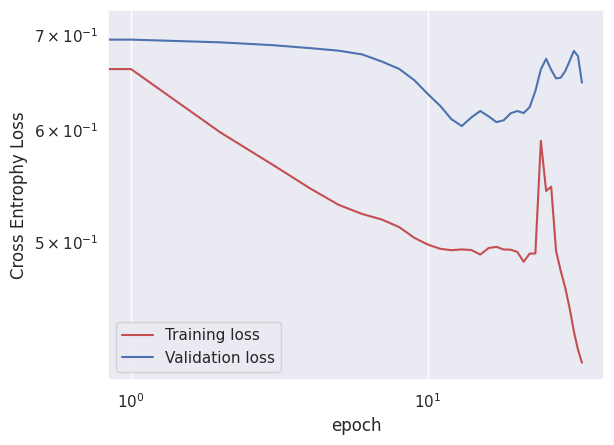

In [25]:
train_ann.plot_loss() #error here

### Plot embeddings

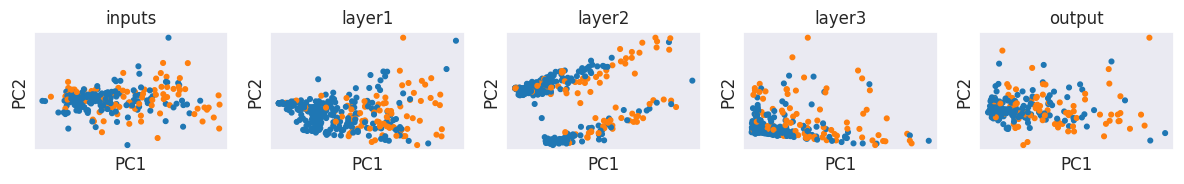

In [26]:
train_ann.plot_pca()

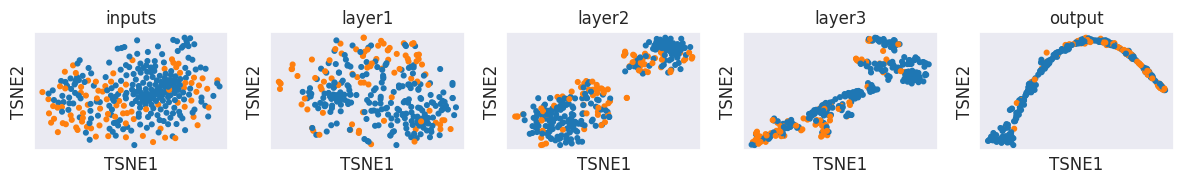

In [27]:
train_ann.plot_tsne()

### plot weights of final layer

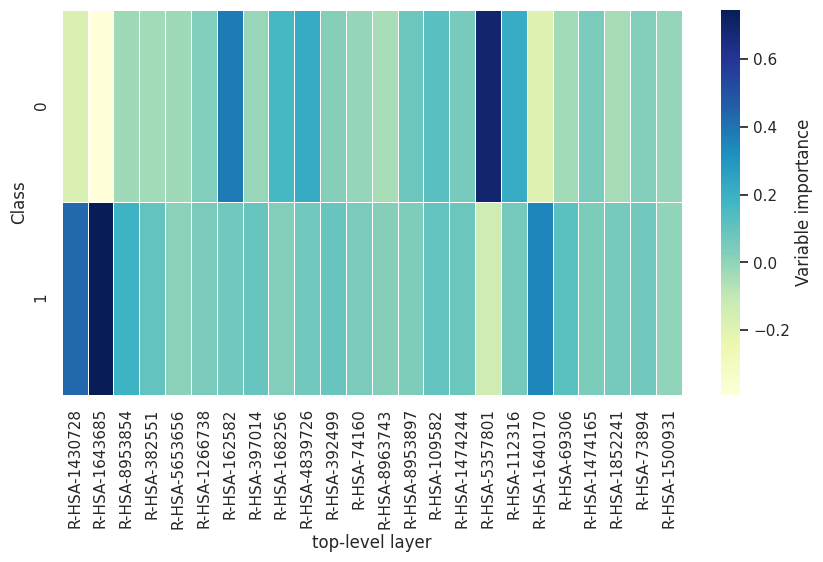

In [28]:
train_ann.plot_weights_of_last_layer()

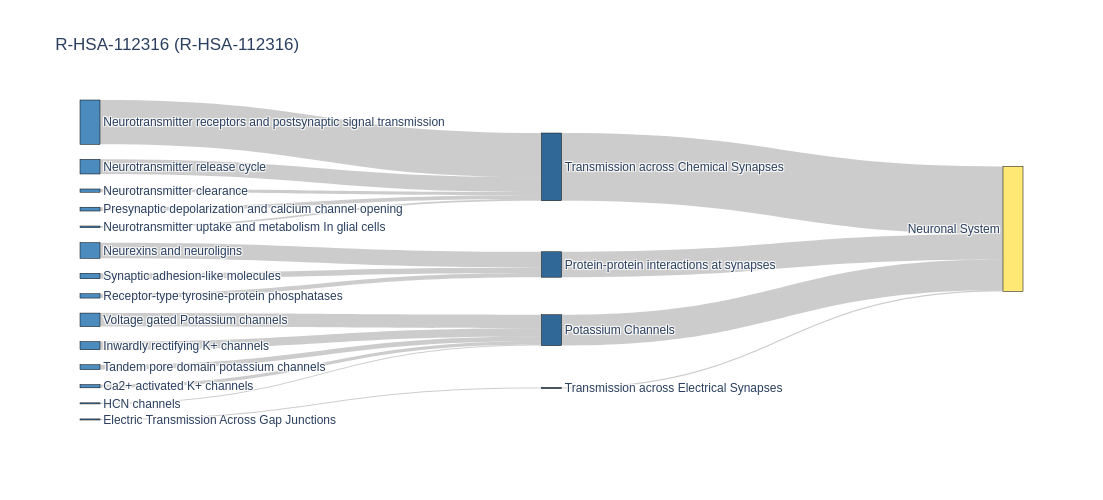

In [29]:
train_ann.plot_subnetwork(names_df, 'R-HSA-112316', figheight=500, figwidth=1200)

## GCNConv

In [30]:
args.method = "GCNConv"
gcn = Encoder(map, args=args, bias = False)
train_gcn = TrainModel(model=gcn, graph=data, args=args)

Epoch:24 Training loss: 0.6538423895835876
Epoch:24 Validation loss: 0.7510908246040344
Hi!


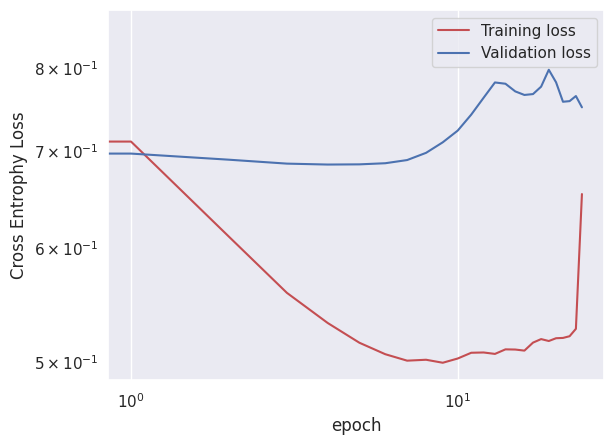

In [31]:
train_gcn.plot_loss()

method       auc  bacc
0  GCNConv  0.527951   0.5

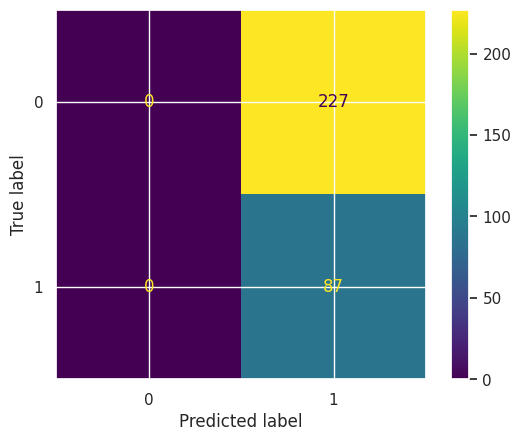

In [32]:
train_gcn.metrics()

### plot embeddings

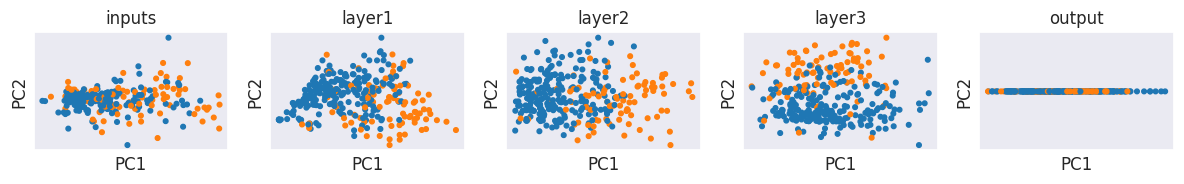

In [33]:
train_gcn.plot_pca()

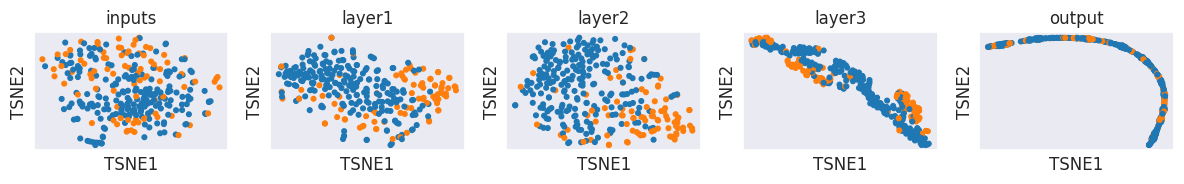

In [34]:
train_gcn.plot_tsne()

### plot weights of final layer

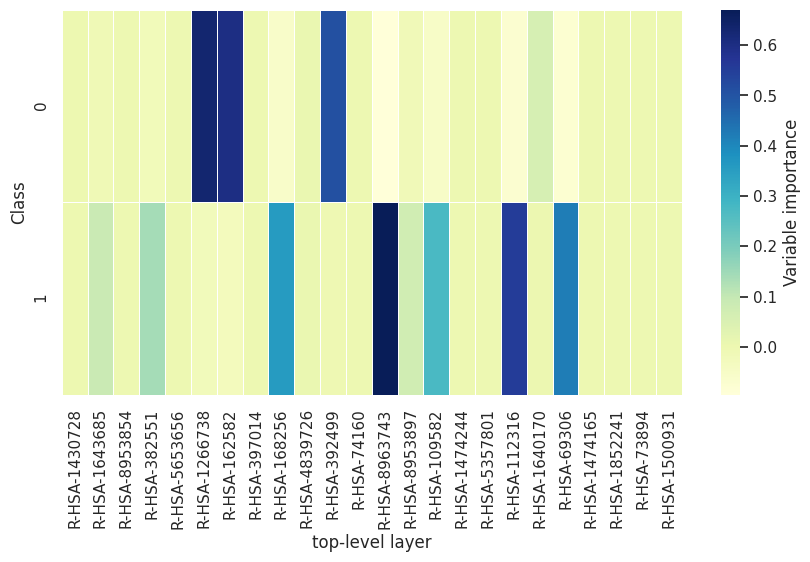

In [35]:
train.plot_weights_of_last_layer()

In [36]:
train.plot_subnetwork(names_df, 'R-HSA-162582', figheight=800, figwidth=1000)

In [37]:
train.plot_subnetwork(names_df, 'R-HSA-69306', figheight=400, figwidth=500)

## GATConv

In [38]:
args.method = "GATConv"
gat = Encoder(map, args=args, bias = False)
train_gat = TrainModel(model=gat, graph=data, args=args)

Epoch:28 Training loss: 0.4794391691684723
Epoch:28 Validation loss: 0.6541344523429871


method       auc     bacc
0  GATConv  0.916933  0.80556

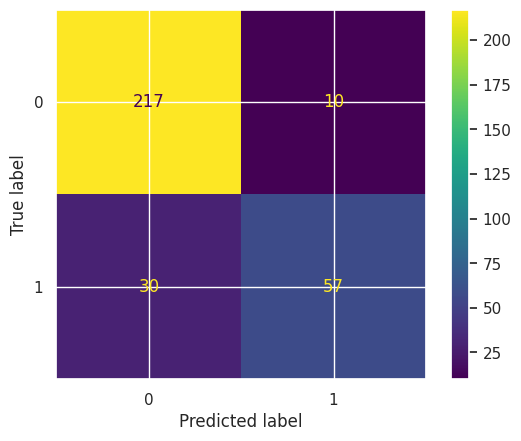

In [39]:
train_gat.metrics()

### plot embeddings

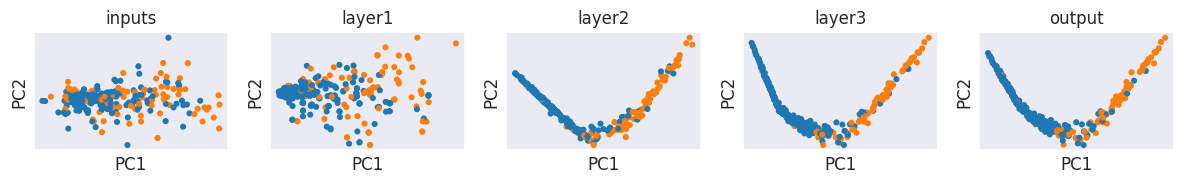

In [40]:
train_gat.plot_pca()

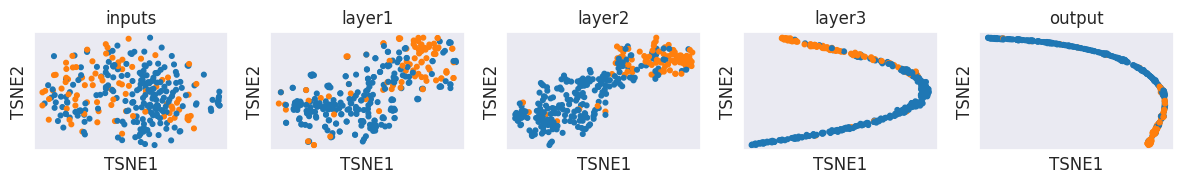

In [41]:
train_gat.plot_tsne()

### plot weights of final layer

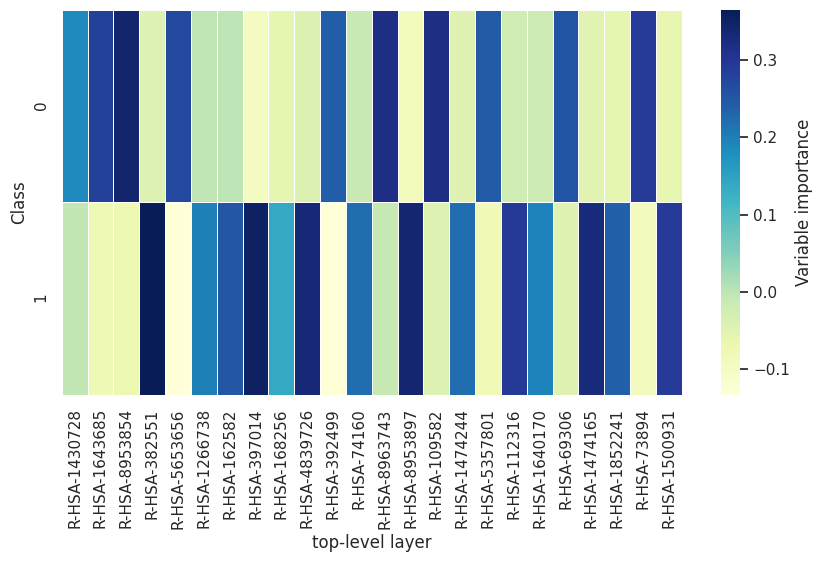

In [42]:
train_gat.plot_weights_of_last_layer()

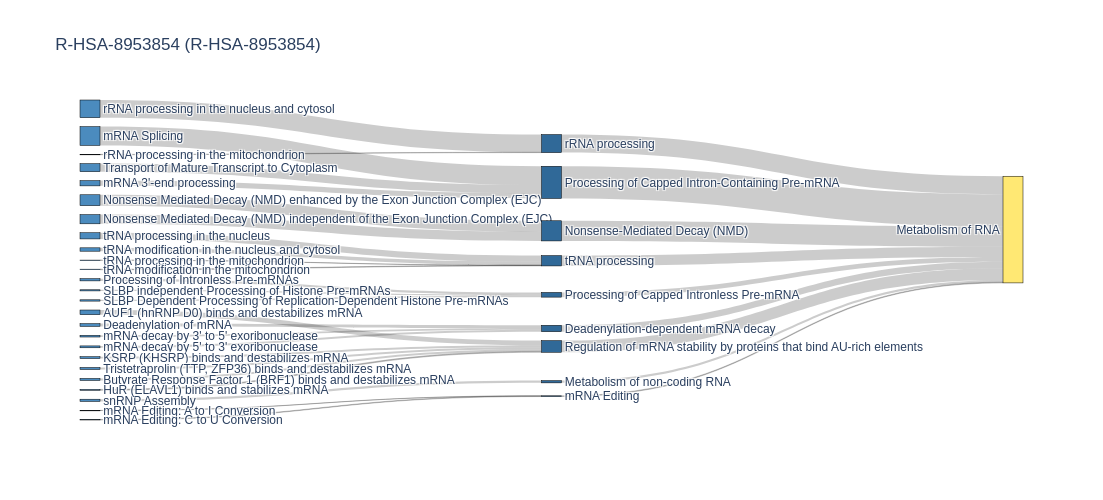

In [43]:
train_gat.plot_subnetwork(names_df, 'R-HSA-8953854', figheight=500, figwidth=1200)